In [141]:
import numpy as np
from time import time
from lloyd_utils import lloyd_update, calc_sq_distances
from kernel_utils import kernel_matrix
from quality_utils import calc_silhouettes

In [142]:
class KKMeans():
    def __init__(self, n_clusters=8, init="random", n_init=1,
                 max_iter=300, tol=0, q_metric="inertia", verbose=0,
                 seed=None, algorithm="lloyd", kernel="linear", **kwargs):
        self.n_clusters = n_clusters
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.q_metric = q_metric
        self.verbose = verbose
        self.rng = np.random.default_rng(seed)
        self.algorithm = algorithm
        self.kernel = kernel
        self.kwargs = kwargs
        self.labels = None
        self.inner_sums = np.zeros(n_clusters)
        self.cluster_sizes = None
        self.trained_data = None
    
    def kernel_wrapper(self, X, Y=None):
        return kernel_matrix(X, Y, kernel=self.kernel, **self.kwargs)

    def fit(self, X):
        X = self._sanitize_data(X)
        kernel_matrix = self.kernel_wrapper(X)
        
        labels_store = np.zeros((self.n_init, X.shape[0]), dtype=int)
        inertia_store = np.zeros(self.n_init)
        inner_sums_store = np.zeros((self.n_init, self.n_clusters))
        sizes_store = np.zeros((self.n_init, self.n_clusters), dtype=int)
        
        for init in range(self.n_init):
            start_labels = self._init_labels(X, kernel_matrix)
            if self.algorithm == "lloyd":
                labels, inertia, inner_sums, sizes = self._lloyd(X, kernel_matrix, start_labels)
            else:
                raise ValueError(self.algorithm + " algorithm not implemented")
            labels_store[init] = labels
            inertia_store[init] = inertia
            inner_sums_store[init] = inner_sums
            sizes_store[init] = sizes

        min_index = np.argmin(inertia_store)
        self.labels = labels_store[min_index]
        self.inner_sums = inner_sums_store[min_index]
        self.cluster_sizes = sizes_store[min_index]
        self.trained_data = X
        if self.verbose:
            print("Min " + self.q_metric +":", inertia_store[min_index],
                "Found at init:", min_index + 1)

        
    
    def _sanitize_data(self, X):
        X = np.asarray(X, dtype=np.float64)
        if len(X.shape) != 2:
            raise ValueError("X needs to be 2-d Array")
        if 0 in X.shape:
            raise ValueError("X is empty")
        return X
    
    def _init_labels(self, X, kernel_matrix):
        '''Assign labels to each datapoint by given method'''
        if isinstance(self.init, (list, tuple, np.ndarray)):
            self.init = self._sanitize_centers() 
            return self._assign_to_centers(X, self.init)
        
        elif self.init == "random":
            centers = self.rng.choice(X, self.n_clusters)
            return self._assign_to_centers(X, centers)
        elif self.init == "truerandom":
            return self.rng.integers(0, self.n_clusters, len(X))
        
        elif self.init == "kmeans++":
            return self._kmeanspp(X, kernel_matrix)
        
        raise Exception("Unknown initialisation method")
    
    def _sanitize_centers(self, centers):
        centers = np.asarray(centers, dtype=np.float64)
        if len(centers.shape) != 2:
            raise ValueError("Given centers need to be 2-d array")
        if 0 in centers.shape:
            raise ValueError("Given centers are empty")
        if len(centers) != self.n_clusters:
            raise ValueError("Amount of given centers must be equal to n_clusters")
        return centers
        
    def _assign_to_centers(self, X, centers):
        X_center_kernel = self.kernel_wrapper(X, centers)
        dists_to_centers = np.zeros((len(x), self.n_clusters))
        for cluster in range(self.n_clusters):
            dists_to_centers[:, cluster] = (-2 * X_center_kernel[:, cluster]
                             + self.kernel_wrapper(centers[cluster]))
        return np.argmin(dists_to_centers, axis=1)

    def _kmeanspp(self, X, kernel_matrix):
        dists_to_centers = np.sqrt(self._build_starting_distance(kernel_matrix))
        data_size = X.shape[0]
        for cluster in range(self.n_clusters):
            if cluster == 0:
                index = self.rng.integers(low=0, high=data_size)
            else:
                max_dist_each = np.amin(dists_to_centers[:, :cluster + 1], axis = 1)
                max_dist_each[max_dist_each < 0] = 0 # TODO test if really necessary
                probs = max_dist_each/max_dist_each.sum()
                index = self.rng.choice(len(X), size=1, p=probs)
            center = X[index]
            inner_sum = self.kernel_wrapper(center)
            outer_sum = self.kernel_wrapper(X, center)
            # reshape necessary as kernel_wrapper has 2dim array output
            dists_to_centers[:, cluster] += (-2 * outer_sum + inner_sum).reshape(data_size,)
        
        return np.argmin(dists_to_centers, axis=1)

    def _lloyd(self, X, kernel_matrix, start_labels):
        labels = start_labels
        quality = 0
        for it in range(self.max_iter):
            distances = self._build_starting_distance(kernel_matrix)
            distances, inner_sums, cluster_sizes =\
                    lloyd_update(distances, kernel_matrix, labels, self.n_clusters)
            labels_old = labels
            quality_old = quality
            labels = np.argmin(distances, axis=1)
            if it == 0:
                continue

            if self.tol != 0:
                quality_old = quality
                quality = self._calculate_quality(distances, labels, kernel_matrix)
                if abs(quality - quality_old) < self.tol:
                    self._verbose_output(it, quality)
                    break
            
            if all(labels_old == labels):
                if self.tol == 0:
                    quality = self._calculate_quality(distances, labels, kernel_matrix)
                self._verbose_output(it, quality)
                break
        
        return labels, quality, inner_sums, cluster_sizes
    
    def _verbose_output(self, iteration, quality):
        if self.verbose:
            print("Converged at iteration:", iteration + 1,    
                self.q_metric, quality)
    
    def predict(self, X):
        kernel_matrix = self.kernel_wrapper(X, self.trained_data)
        sq_distances = calc_sq_distances(self.inner_sums, 
                                  self.cluster_sizes,
                                  kernel_matrix,
                                  self.labels, 
                                  self.n_clusters)
        return np.argmin(np.sqrt(sq_distances), axis=1)
    
    def _calculate_quality(self, sq_distances, labels, kernel_matrix):
        if self.q_metric == "inertia":
            return sq_distances[range(sq_distances.shape[0]), labels].sum()
        elif self.q_metric == "silhouette":
            return self.calc_silhouette(sq_distances, labels)
        else:
            raise NotImplementedError(str(self.q_metric) + " quality metric not implemented")
    
    def calc_silhouette(self, sq_distances, labels):
        dists = np.sqrt(sq_distances)
        silhouettes = calc_silhouettes(dists, labels)
        return sum(silhouettes) / len(silhouettes)
    
    def _build_starting_distance(self, kernel_matrix):
        return np.ascontiguousarray(np.tile(np.diag(kernel_matrix), (self.n_clusters, 1)).T)


In [143]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.cluster import KMeans

In [144]:
def visualize(data, labels):
    if len(data[0]) > 3:
        raise Exception("Dimensionality is too high for visualization")
    elif len(data[0]) == 1:
        plt.scatter(data, [0 for x in range(len(data))], c = labels)
    elif len(data[0]) == 2:
        plt.scatter(data[:,0], data[:,1], c = labels)
    elif len(data[0]) == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection = "3d")
        ax.scatter(data[:,0], data[:,1], data[:,2], c = labels)

In [148]:
x, labels, centers = make_blobs(5000, centers = 5, return_centers = True, random_state = 0, n_features = 2)

In [153]:
kkm = KKMeans(n_clusters = 5, verbose = True, init = "kmeans++", kernel = "linear", seed = 0, q_metric="inertia")

Converged at iteration: 13 inertia 9011.887122084234
Min inertia: 9011.887122084234 Found at init: 1
0.3753526210784912


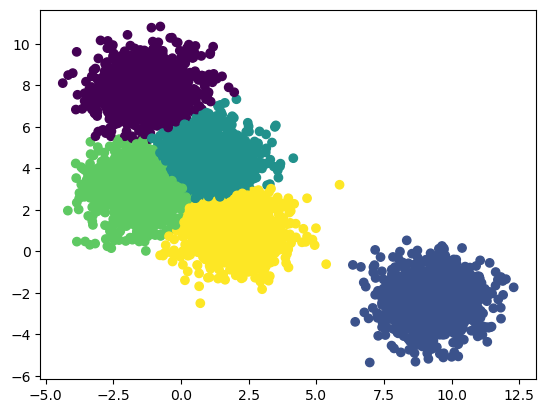

In [154]:
start = time()
kkm.fit(x)
end = time()
print(end - start)
visualize(x, kkm.labels)

In [127]:
x, l = make_circles(7000, factor = 0.4, random_state=0)

In [132]:
kkm = KKMeans(n_clusters = 2, verbose = True, init = "kmeans++", kernel = "rbf", seed = 0, tol = 1e-4, variance=0.5, n_init = 5)

Converged at iteration: 45 inertia 5199.344133335367
Converged at iteration: 45 inertia 5199.344133335365
Converged at iteration: 15 inertia 5083.541958166221
Converged at iteration: 46 inertia 5199.344133335364
Converged at iteration: 46 inertia 5199.344133335366
Min inertia: 5083.541958166221 Found at init: 3
4.440989255905151


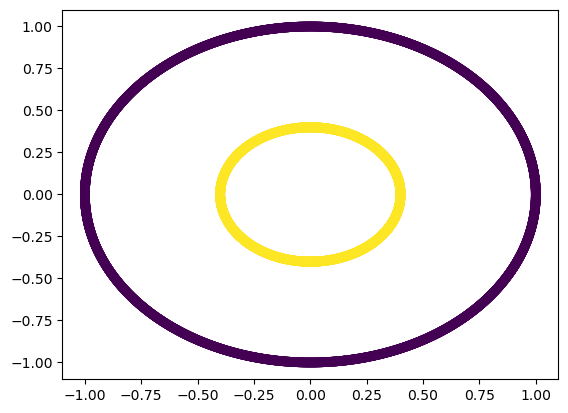

In [133]:
start = time()
kkm.fit(x)
end = time()
print(end - start)
visualize(x, kkm.labels)

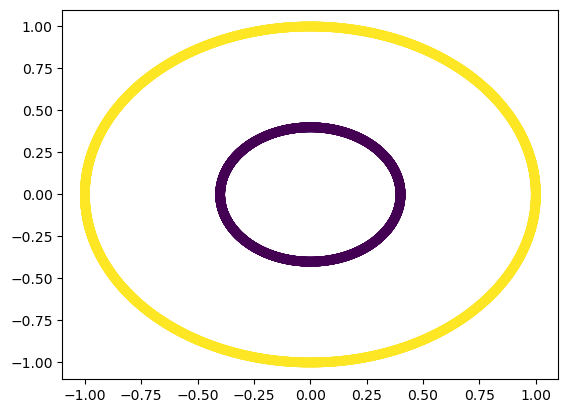

In [26]:
visualize(x, kkm.predict(x))

In [27]:
all(kkm.predict(x) == kkm.labels)

True

In [29]:
times = 0.
for i in range(20):
    s = time()
    kkm.predict(x)
    e = time()
    times += e - s
print(times/20)


0.15258704423904418
